In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
DATA_PATH = './data/'
MODELS_PATH = './models/'
CHECKPOINTS_PATH = './checkpoints/'

## Training

In [ ]:
# Load data

BATCH_SIZE = 32
IMG_WIDTH = 180
IMG_HEIGHT = 180
VALIDATION_SPLIT = 0.2
DATASET_FROM_DIRECTORY_SEED = 111

# train_ds and validation_ds separated because tensorflow 2.8.3 is being used to avoid data augmentation problems with >2.10

train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_PATH,
    subset='training',
    validation_split=VALIDATION_SPLIT,
    seed=DATASET_FROM_DIRECTORY_SEED,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE
    )

validation_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_PATH,
    subset='validation',
    validation_split=VALIDATION_SPLIT,
    seed=DATASET_FROM_DIRECTORY_SEED,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE
    )

In [ ]:
# Get a few samples from the training dataset and plot them

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1) :
    for i in range(9) :
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")

In [11]:
# Model definition

EPOCHS = 20
PATIENCE = 2

class Model(tf.keras.Model) :
    def __init__(self, n_conv_layers = 1, n_filters = 32, convlayers_dropout = 0.2, dense_dropout = 0.4) :
        super().__init__()
        
        # Data Augmentation
        self.random_flip = tf.keras.layers.RandomFlip('horizontal', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
        self.random_rotation = tf.keras.layers.RandomRotation(0.1)
        self.random_zoom = tf.keras.layers.RandomZoom(0.1)
        
        self.rescaling = tf.keras.layers.Rescaling(1./255)
        
        self.conv2dlayers = [] 
        
        for i in range(n_conv_layers) :
            self.conv2dlayers.append(
                    (
                        tf.keras.layers.Conv2D(n_filters * (i + 1), 3, activation='relu', padding='same'),
                        tf.keras.layers.MaxPool2D(),
                        tf.keras.layers.BatchNormalization(),
                        tf.keras.layers.Dropout(convlayers_dropout)
                    )
                )
        
        self.flatten = tf.keras.layers.Flatten()
        
        self.dense1 = tf.keras.layers.Dense(128, activation='relu')
        self.dropout1 = tf.keras.layers.Dropout(dense_dropout)
        
        self.softmax = tf.keras.layers.Dense(2, activation='softmax')
        
        self.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
    def call(self, inputs, training=False) :
        
        x = self.random_flip(inputs)
        x = self.random_rotation(x)
        x = self.random_zoom(x)
        
        x = self.rescaling(x)
        
        for conv, maxpool, bn, dropout in self.vvg :
            x = conv(x)
            x = maxpool(x)
            x = bn(x)
            x = dropout(x)
                
        x = self.flatten(x)
        x = self.dense1(x)
        
        return self.softmax(x)     
    
    def summary(self):
        x = tf.keras.Input(shape=(180, 180, 3))
        model = tf.keras.models.Model(inputs=[x], outputs=self.call(x))
        return model.summary()           
    
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)
]    
    
models = [
    ('64', Model(n_conv_layers=3, n_filters=64, convlayers_dropout=0.3, dense_dropout=0.5)),
]

In [ ]:
# Train and save models

for model_name, model in models :
    model.fit(train_ds, validation_data=validation_ds, epochs=EPOCHS, verbose=2, callbacks=callbacks)    
    model.save('{}{}'.format(MODELS_PATH, model_name), save_format='tf')

In [ ]:
def plot_val_accuracy(models) :
    fig, ax = plt.subplots()
    
    ax.grid(axis='y')
    ax.set_xticks(range(0, EPOCHS))

    for model_name, model in models :
        ax.plot(model.history.history['val_accuracy'], label=model_name)

    plt.legend()
    plt.show()    
    
def plot_val_loss(models) :
    fig, ax = plt.subplots()
    
    ax.grid(axis='y')
    ax.set_xticks(range(0, EPOCHS))

    for model_name, model in models :
        ax.plot(model.history.history['val_loss'], label=model_name)

    plt.legend()
    plt.show()
    
def plot_overview(models) :    
    fig, ax = plt.subplots()
    
    ax.grid(axis='y')
    ax.set_xticks(range(0, EPOCHS))

    for model_name, model in models :
        ax.plot(model.history.history['val_accuracy'], label='{} - val_accuracy'.format(model_name))
        ax.plot(model.history.history['val_loss'], label='{} - val_loss'.format(model_name), linestyle='dashed', c = ax.get_lines()[-1].get_color())

    plt.legend()
    plt.show()
    
plot_overview(models)

## Load existing model

In [8]:
models = [
    ('64', tf.keras.models.load_model('./models/64/'))
]

## Predict

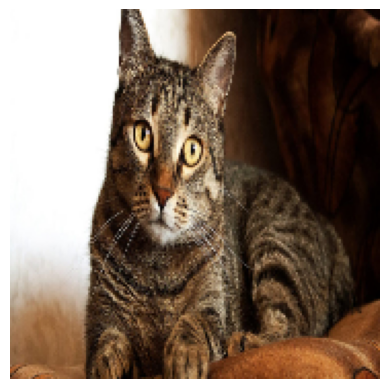

Model 64 prediction
93.88% cat
6.12% dog



In [10]:
img = tf.keras.utils.load_img('./cat.jpg', target_size=(180, 180))

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

plt.axis('off')
plt.imshow(img)
plt.show()

for model_name, model in models :
    predictions = model.predict(img_array)
    cat_percentage = predictions[0][0] * 100
    dog_percentage = predictions[0][1] * 100
    print('Model {} prediction\n{:.2f}% cat\n{:.2f}% dog\n'.format(model_name, cat_percentage, dog_percentage))